In [1]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18
wavelength, flux, err = load_binned_data()
wavelength2, flux2, err2 = load_binned_data('/Users/arcticfox/Documents/AUMic/reduced2/binned_data2.npy')

times = np.load('/Users/arcticfox/Documents/AUMic/reduced/times.npy')
orbits = np.load('/Users/arcticfox/Documents/AUMic/reduced/orbits.npy')
times2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/times2.npy')
orbits2 = np.load('/Users/arcticfox/Documents/AUMic/reduced2/orbits2.npy')+5

wavelength = np.full(flux.shape, wavelength)
wavelength2 = np.full(flux2.shape, wavelength2)

parula = np.load('/Users/arcticfox/parula_colors.npy')#[np.linspace(0,210,len(times),dtype=int)]

In [2]:
np.append(flux, flux2, axis=0).shape

(804, 18725)

In [3]:
fwc = FlaresWithCOS(wavelength=np.append(wavelength, wavelength2, axis=0), 
                    flux=np.append(flux, flux2, axis=0),
                    flux_err=np.append(err, err2, axis=0), 
                    time=np.append(times, times2), 
                    orbit=np.append(orbits, orbits2))
fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')

In [4]:
fwc.measure_FUV130()

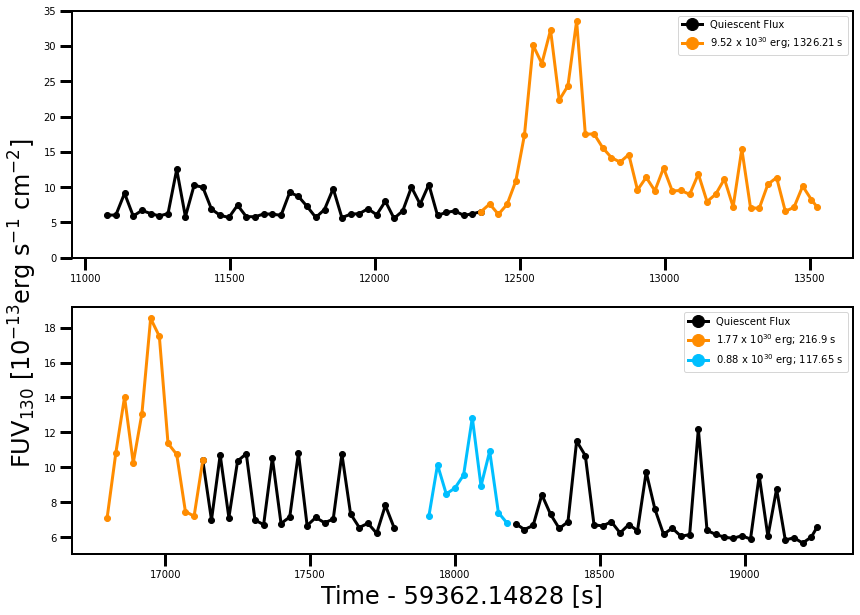

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(14,10))
fig.set_facecolor('w')

distance = (9.79 * units.pc).to(units.cm)

q = ((fwc.orbit == 2) & (fwc.time.value<=12370))
f = ((fwc.orbit == 2) & (fwc.time.value>=12350))
energy, duration = fwc.measure_flare_params(q, f, distance, 
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'
ax1.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax1.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, label=label, marker='o')
ax1.set_ylim(0,35)
#ax1.set_xlim(11100,13550)
ax1.legend()


q = ((fwc.orbit == 3) & (fwc.time.value>=17120) & (fwc.time.value<=17800.943))
f = ((fwc.orbit == 3) & (fwc.time.value<=17140))
energy, duration = fwc.measure_flare_params(q, f, distance,
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3,
         label='Quiescent Flux', marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13, 'darkorange', lw=3, marker='o', label=label)



q = ((fwc.orbit == 3) & (fwc.time.value>=18200))
f = ((fwc.orbit == 3) & (fwc.time.value>=17880.943) & (fwc.time.value<=18200.943))
energy, duration = fwc.measure_flare_params(q, f, distance,
                                            flux=fwc.fuv130*10**-13)
label = str(np.round(energy.value/10**30,2)) + ' x 10$^{30}$ erg; '+ str(np.round(duration.value, 2)) + ' s'

ax2.plot(fwc.time[q], fwc.fuv130[q]/10**-13, 'k', lw=3, marker='o')
ax2.plot(fwc.time[f], fwc.fuv130[f]/10**-13,'deepskyblue', marker='o', lw=3, label=label)


ax2.legend()
ax2.set_ylabel('FUV$_{130}$ [10$^{-13}$erg s$^{-1}$ cm$^{-2}$]', y=1.02, fontsize=24)
ax2.set_xlabel('Time - 59362.14828 [s]', fontsize=24)


plt.subplots_adjust(hspace=0.2)
#plt.savefig('fuv130_flares.png', dpi=250, rasterize=True, bbox_inches='tight')

In [6]:
for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

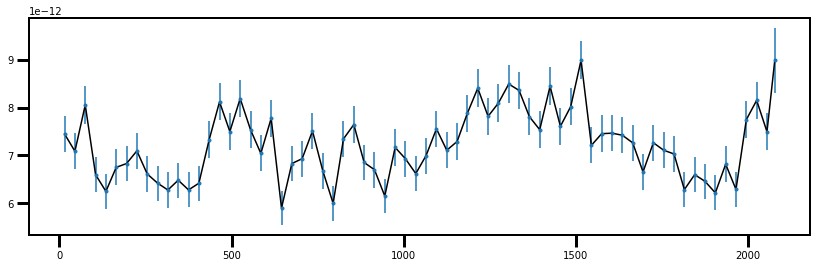

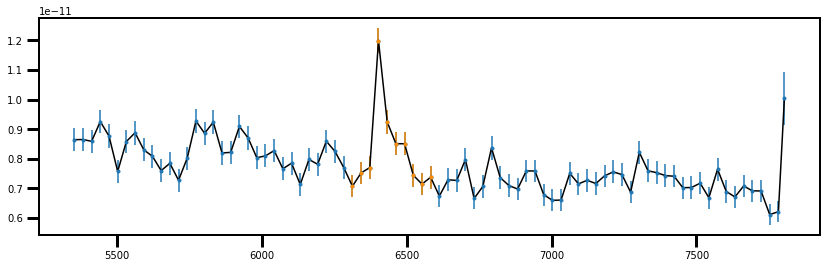

0 1
1 2


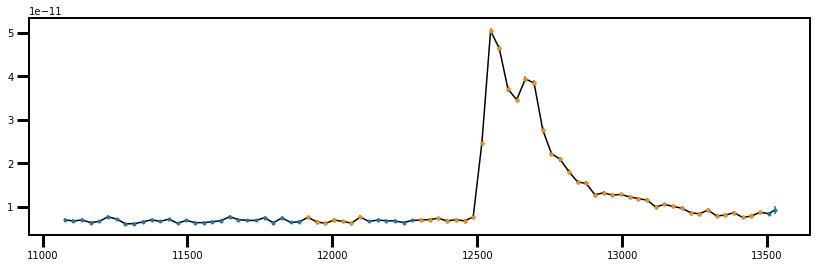

0 3
1 4


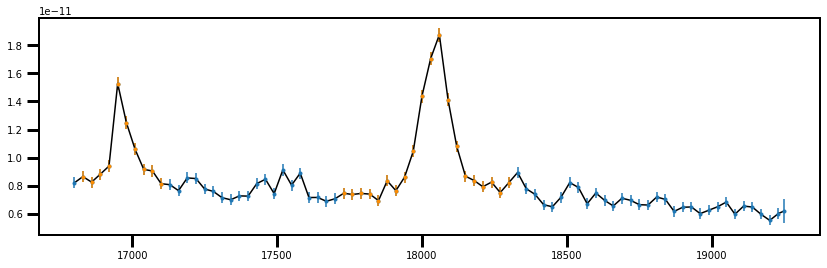

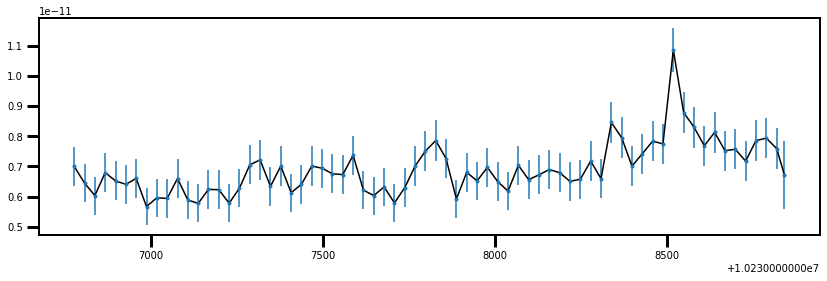

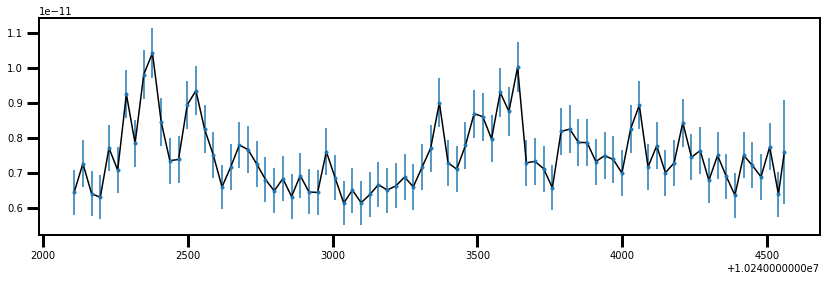

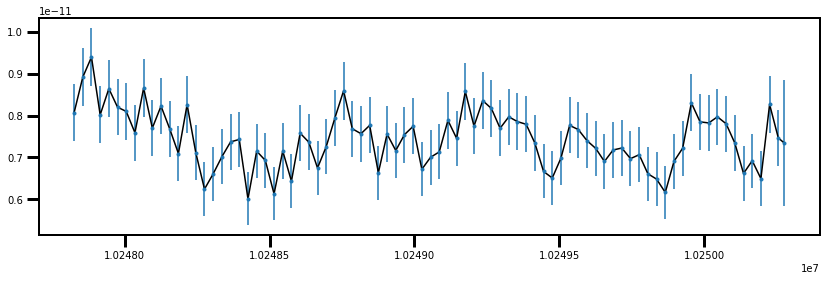

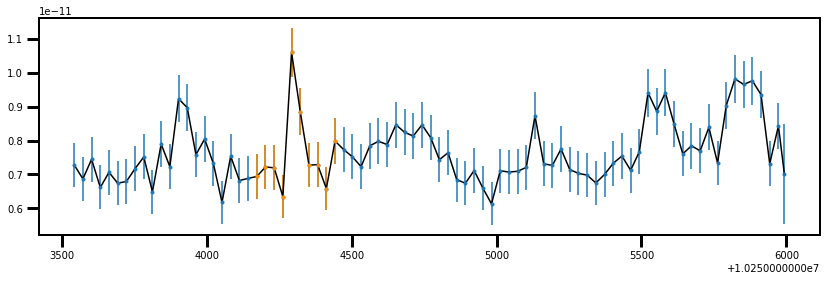

0 6
1 7
2 8
3 9
4 10


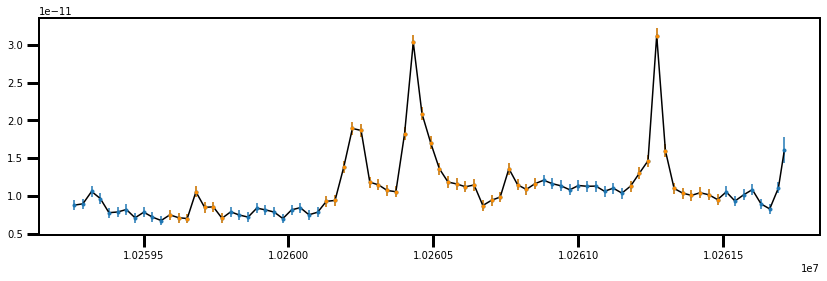

In [7]:
diff = np.where(np.diff(fwc.time.value)>100000)[0]
diff = [0, diff[0], len(fwc.time)-1]

f_tot = np.full((20,len(fwc.time.value)), False)
x = 0

for i in range(len(diff)-1):
    if i == 0:
        jr = [0,4]
    else:
        jr = [5,10]
        
    for j in range(jr[0], jr[1]):
        plt.figure(figsize=(14,4))
        mask = np.where((fwc.time.value>=fwc.time.value[diff[i]]) &
                        (fwc.time.value<=fwc.time.value[diff[i+1]]) &
                        (fwc.orbit==j))
        plt.errorbar(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 
                     yerr=fwc.error_table['CIII'][mask]/3, 
                     marker='.',
                     linestyle='')
        plt.plot(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 'k')
        if j == 1:
            f = ((fwc.time.value>=6300) & (fwc.time.value<=6600))
        elif j == 2:
            f1 = ((fwc.time.value>=11900) & (fwc.time.value<=12100))
            f2 = ((fwc.time.value>=12300) & (fwc.time.value<=13500)) 
            f = np.array([f1, f2])
        elif j == 3:
            f1 = ((fwc.time.value>=16800) & (fwc.time.value<=17100) )
            f2 = ((fwc.time.value>=17700) & (fwc.time.value<=18300) ) 
            f = np.array([f1, f2])
        elif j == 8:
            f = ((fwc.time.value>=10254152) & (fwc.time.value<=10254452))
        elif j == 9:
            f0 = ((fwc.time.value>=10259581) & (fwc.time.value<=10259781))
            f1 = ((fwc.time.value>=10260101) & (fwc.time.value<=10260351))
            f2 = ((fwc.time.value>10260351) & (fwc.time.value<=10260651))
            f3 = ((fwc.time.value>10260651) & (fwc.time.value<=10260851))
            f4 = ((fwc.time.value>10261151) & (fwc.time.value<=10261501))
            f = np.array([f0, f1, f2, f3, f4])
        else:
            f = None
            
        if f is not None:
            if len(f.shape) > 1:
                mask = np.nansum(f, axis=0) == 1
                for n in range(len(f)):
                    print(n, x)
                    f_tot[x] = f[n]
                    x += 1  
            else:
                mask = f == True
                f_tot[x] = f
                x += 1
            plt.errorbar(fwc.time.value[mask], 
                         fwc.width_table['CIII'][mask], 
                         yerr=fwc.error_table['CIII'][mask]/3, 
                         marker='.', color='darkorange',
                         linestyle='')
            
        
        plt.show()

In [8]:
f_tot = np.delete(f_tot, np.arange(x,len(f_tot),1,dtype=int),axis=0)

In [9]:
np.save('/Users/arcticfox/Documents/AUMic/flare_mask.npy', [fwc.time, f_tot])

//anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


4.735229790255231e+29 erg 60.13616707701091 s


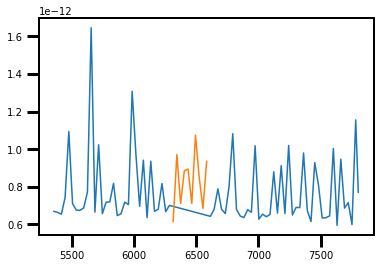

-3.207849070172087e+29 erg -34.52363355324515 s


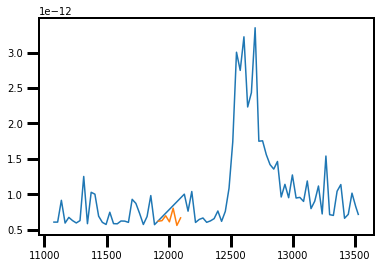

9.159702947677347e+30 erg 1242.5426826461455 s


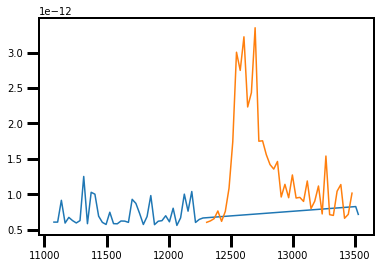

1.7244519799264374e+30 erg 218.75824091779518 s


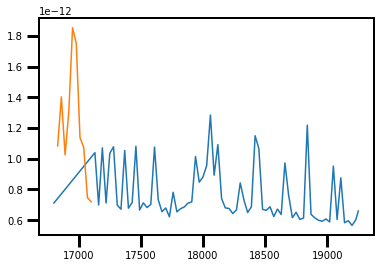

7.096446760751689e+29 erg 88.57350773979792 s


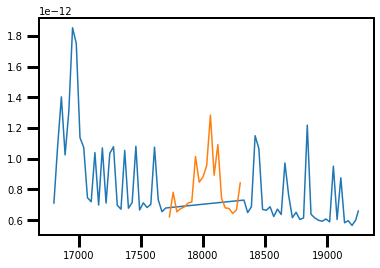

1.0752329626497527e+29 erg 13.318300441321924 s


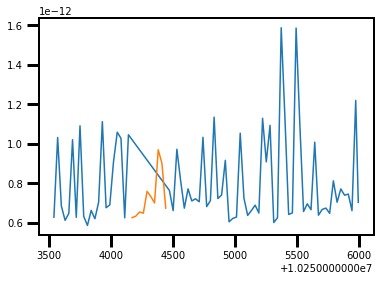

-3.867206454895773e+29 erg -37.627430139388245 s


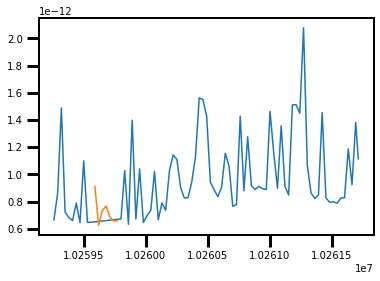

1.171054949642721e+29 erg 11.506769470650969 s


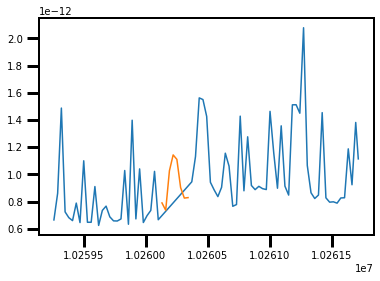

8.748769303287365e+29 erg 88.64823247071317 s


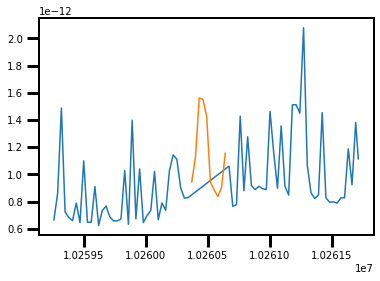

2.737664867673405e+29 erg 26.92756112686788 s


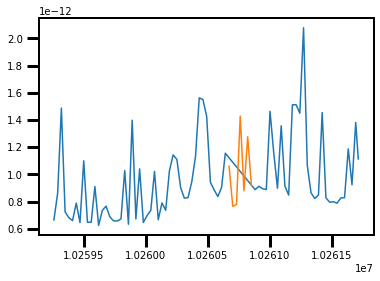

1.1041562828133727e+30 erg 108.60436626174831 s


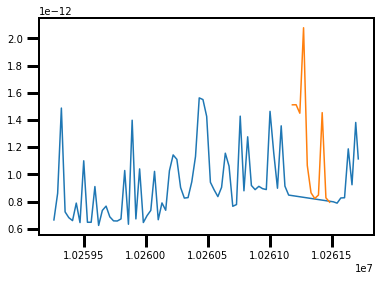

In [10]:
for i in range(len(f_tot)):
    which_o = np.where(fwc.time.value >= fwc.time[f_tot[i]][0].value)[0][0]
    q = ((fwc.orbit == fwc.orbit[which_o]) & (f_tot[i] == False))
    plt.plot(fwc.time[q], fwc.fuv130[q])
    plt.plot(fwc.time[f_tot[i]], fwc.fuv130[f_tot[i]])
    
    e, d = fwc.measure_flare_params(qmask=q, fmask=f_tot[i], d=distance)
    print(e*1e-13,d)
    
    plt.show()